# HW 4 - Inverse RL & GRPO Fine-Tuning

Reward modeling is the glue between human supervision and scalable RL systems. Classical inverse reinforcement learning (IRL) lets us infer reward functions directly from expert demonstrations, and that same idea underpins modern training pipelines (r.g. RLHF, RLAIF, Constitutional AI) where we fit reward models or preference models for large language models. Even though today's top AI labs rely on pairwise/ranked preference data or verifiable rewards rather than tabular MaxEnt IRL, the maximum entropy view is a foundational recipe: it teaches us to match feature expectations while keeping the trajectory distribution as high-entropy (i.e., as uncertain) as possible away from labeled data, which is a philosophy we still enforce when training modern reward models.

In **Section 1**, we will apply Maximum Entropy Inverse Reinforcement Learning (MaxEnt IRL) algorithm from [Ziebart et al., 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf) to recover rewards from demonstrations.

In **Section 2**, we will fine-tune a QLoRA-adapted large language model with the Group Relative Policy Optimization (GRPO) algorithm from [Shao et al., 2024](https://arxiv.org/abs/2402.03300) so the LLM outputs follow structured reasoning formats.


**Runtime requirement.** This notebook assumes access to a GPU (MaxEnt IRL visualization is light, but GRPO + QLoRA fine-tuning will not run on CPU). If you are using Google Colab, open `Runtime → Change runtime type` and set the hardware accelerator to `GPU`, then restart the runtime before continuing.

To conserve GPU hours, we recommend leaving the notebook on a CPU runtime while you work through Section 1 and the early GRPO setup cells. Switch to a GPU only once you reach the GRPO training section where accelerated generation becomes necessary.


In [ ]:
# If running on Colab (recommended)
!pip install -U transformers datasets accelerate bitsandbytes peft math-verify

## 1. Maximum Entropy IRL [40 pts]

1. Conceptual questions [12 pts]
2. MaxEnt IRL implementation [28 pts]

Maximum Entropy IRL (Ziebart et al., 2008) infers a reward function that explains expert demonstrations while remaining as uncertain as possible beyond the observed behavior. By matching feature expectations under a stochastic policy, we recover rewards that generalize better than directly cloning actions.

**Suggested resources.**
- B. D. Ziebart et al., *Maximum Entropy Inverse Reinforcement Learning*, AAAI 2008
- B. D. Ziebart, *Modeling Purposeful Adaptive Behavior with the Principle of Maximum Causal Entropy*, PhD thesis, 2010
- S. Levine, *Reinforcement Learning and Control as Probabilistic Inference*, NeurIPS 2018 tutorial

The exercises that follow rebuild the MaxEnt IRL pipeline from demonstrations.

### The IRL objective

We work with a Markov decision process $(S, A, T, R, \gamma)$ where transitions $T(s_t, a_t, s_{t+1})$ and the discount $\gamma$ are known while the per-state reward $R(s)$ is not. Reinforcement learning searches for a policy $\pi$ that maximizes expected discounted return, but in inverse RL we only watch demonstrations $\mathcal{D} = \{\tau_i\}$ produced by an expert policy $\pi^E$. Each trajectory $\tau = ((s_0, a_0), \ldots, s_T)$ is summarized through hand-crafted features $\phi: S \to \mathbb{R}^d$, and we assume a linear reward $R_\omega(s) = \omega^\top \phi(s)$. The goal is to recover parameters $\omega$ whose induced behavior explains the demonstrations as well as the original expert policy.


### Principle of Maximum Entropy

Feature-expectation matching requires the learner to visit features just as often as the expert does,
$$
    \mathbb{E}_{\pi^L}[\phi(\tau)] = \mathbb{E}_{\pi^E}[\phi(\tau)],
$$
where the learner's policy $\pi^L$ emerges from the trajectory distribution $p(\tau)$. This constraint alone leaves infinitely many rewards that can explain $\mathcal{D}$. Following Jaynes (1957) and Ziebart et al. (2008), we pick the solution with maximum entropy so that we add no extra bias beyond the data we observed. Intuitively, higher-entropy distributions encode fewer additional assumptions—if two policies both satisfy the feature constraints, we prefer the one whose trajectories remain as uncertain as possible.


### Trajectory distributions, gradients, and state visitation frequencies

Applying Lagrange multipliers yields a trajectory distribution of the form
$$
    p(\tau \mid \omega) = \frac{1}{Z(\omega)} \exp(\omega^\top \phi(\tau)) \prod_{t} p(s_{t+1} \mid s_t, a_t),
$$
with partition function $Z(\omega)$ ensuring normalization. Maximizing the log-likelihood of the demonstrations leads to the gradient
$$
    \nabla_\omega \mathcal{L}(\omega) = \mu_E - \sum_s D_s\, \phi(s),
$$
where $\mu_E$ is the empirical feature expectation and $D_s$ is the time-aggregated expected state-visitation frequency (sum over all time steps) under the current reward. In the forward recursion below we will write $d_t(s)$ for the per-time-step visitation frequency at horizon index $t$, so that $D_s = \sum_t d_t(s)$. Computing $D_s$ requires a backward pass for the partition functions ($Z_{s,a}$ and $Z_s$ provide the local action probabilities $\pi(a \mid s) = Z_{s,a} / Z_s$) followed by a forward rollout that propagates visitation counts from the initial-state distribution. These are the exact steps implemented below.


### 1.a Conceptual Questions [12 pts total; 3 pts each]

1. Two demonstrations $\tau_1$ and $\tau_2$ accumulate feature sums $F_1$ and $F_2$. Under the MaxEnt IRL distribution, write the log-odds $\log p(\tau_1 \mid \omega) - \log p(\tau_2 \mid \omega)$ and state when the odds become zero.
<font color="blue">Since $p(\tau \mid \omega) = \frac{1}{Z(\omega)} \exp(\omega^\top \phi(\tau)) \prod_t p(s_{t+1} \mid s_t, a_t)$, the log-odds are:
$$\log p(\tau_1 \mid \omega) - \log p(\tau_2 \mid \omega) = \omega^\top \phi(\tau_1) - \omega^\top \phi(\tau_2) = \omega^\top (F_1 - F_2)$$
The partition function $Z(\omega)$ and dynamics cancel out. The odds become zero (equal probability) when $\omega^\top F_1 = \omega^\top F_2$, i.e., when the two trajectories have identical total reward under the current parameters.</font>

2. Explain what goes wrong if you try to roll out expected visitation frequencies before finishing the backward partition pass.
<font color="blue">The forward visitation recursion requires the soft-optimal policy $\pi(a \mid s) = Z_{s,a} / Z_s$ to propagate probability mass. Without completing the backward pass to compute the partition functions $Z_s$ and $Z_{s,a}$, we have no policy to determine the action distribution at each state, making the forward rollout impossible.</font>

3. Provide the forward recursion for the expected visitation frequencies $d_{t+1}(s')$ **and** state how you prevent terminal states from re-emitting probability mass.
<font color="blue">The forward recursion is:
$$d_{t+1}(s') = \sum_{s,a} d_t(s)\,\pi(a\mid s)\,P(s'\mid s,a)$$
To prevent terminal states from re-emitting probability mass, we skip the propagation step when $s$ is in the terminal set—terminal states should not initiate any outgoing transitions in the forward pass.</font>

4. Name one numerical-stability technique for the partition or visitation computations and briefly describe how it mitigates underflow/overflow.
<font color="blue">Log-space computation with the log-sum-exp trick. Instead of directly computing $\exp(r(s))$ and partition sums which can overflow/underflow, we work in log-space: $\log Z = \log \sum_i \exp(x_i) = \max_i x_i + \log \sum_i \exp(x_i - \max_i x_i)$. This keeps intermediate values numerically stable by preventing both very large exponentials (overflow) and very small probabilities (underflow).</font>

### 1.b MaxEnt IRL Implementation [28 pts]

Implement the four helpers below (feature expectations, initial-state distribution, expected state visitation frequencies, and the exponentiated-gradient solver). Section 1 unit tests check them in the same order.


### Section 1 implementation roadmap

The next three code cells are boilerplate: they define the GridWorld dynamics, trajectory containers, and data-generation utilities shared by this notebook. Skim them for context, but there is no TODO or grading logic inside.


In [ ]:
import numpy as np
from dataclasses import dataclass
from itertools import product
from typing import Callable, Iterable, List

# -------------------------------
# Grid world dynamics
# -------------------------------

class GridWorld:
    def __init__(self, size: int):
        self.size = size
        self.actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        self.n_actions = len(self.actions)
        self.n_states = size * size
        self.p_transition = self._build_transition_table()

    def state_index_to_point(self, state: int):
        return state % self.size, state // self.size

    def state_point_to_index(self, point):
        x, y = point
        return y * self.size + x

    def _clip_point(self, point):
        x, y = point
        x = min(max(x, 0), self.size - 1)
        y = min(max(y, 0), self.size - 1)
        return x, y

    def _step_intended(self, state: int, action: int):
        x, y = self.state_index_to_point(state)
        dx, dy = self.actions[action]
        return self.state_point_to_index(self._clip_point((x + dx, y + dy)))

    def _build_transition_table(self):
        table = np.zeros((self.n_states, self.n_states, self.n_actions), dtype=np.float32)
        for s_from, s_to, a in product(range(self.n_states), range(self.n_states), range(self.n_actions)):
            table[s_from, s_to, a] = self._transition_prob(s_from, s_to, a)
        return table

    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]

        # deterministic transition defined by action
        if fx + ax == tx and fy + ay == ty:
            return 1.0

        # we can stay at the same state if we would move over an edge
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                return 1.0

        return 0.0


class IcyGridWorld(GridWorld):
    def __init__(self, size: int, p_slip: float):
        self.p_slip = p_slip
        super().__init__(size)

    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]

        # intended transition defined by action
        if fx + ax == tx and fy + ay == ty:
            return 1.0 - self.p_slip + self.p_slip / self.n_actions

        # we can slip to all neighboring states
        if abs(fx - tx) + abs(fy - ty) == 1:
            return self.p_slip / self.n_actions

        # we can stay at the same state if we would move over an edge
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                    return 1.0 - self.p_slip + 2.0 * self.p_slip / self.n_actions
                return 1.0 - self.p_slip + self.p_slip / self.n_actions

            if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                return 2.0 * self.p_slip / self.n_actions
            if not 0 < fx < self.size - 1 or not 0 < fy < self.size - 1:
                return self.p_slip / self.n_actions
            return 0.0

        return 0.0


def state_features(world: GridWorld) -> np.ndarray:
    return np.eye(world.n_states, dtype=np.float32)



In [ ]:
# -------------------------------
# Trajectories and solvers
# -------------------------------

@dataclass
class Transition:
    s_from: int
    action: int
    s_to: int


class Trajectory:
    def __init__(self, transitions: List[Transition]):
        self._transitions = transitions

    def transitions(self) -> List[Transition]:
        return self._transitions

    def state_sequence(self) -> np.ndarray:
        states = [tr.s_from for tr in self._transitions]
        if self._transitions:
            states.append(self._transitions[-1].s_to)
        return np.asarray(states, dtype=np.int64)


def generate_trajectory(world: GridWorld, policy_logits: np.ndarray, start: int, terminal: Iterable[int], rng: np.random.Generator) -> Trajectory:
    state = start
    transitions = []
    while state not in terminal:
        probs = policy_logits[state]
        action = rng.choice(world.n_actions, p=probs)
        next_state = rng.choice(world.n_states, p=world.p_transition[state, :, action])
        transitions.append(Transition(state, action, next_state))
        state = next_state
    return Trajectory(transitions)


def generate_trajectories(world: GridWorld, policy_logits: np.ndarray, start_states: np.ndarray, terminal: Iterable[int], n_trajectories: int, seed: int = 0) -> List[Trajectory]:
    rng = np.random.default_rng(seed)
    demos = []
    for _ in range(n_trajectories):
        s0 = rng.choice(start_states)
        demos.append(generate_trajectory(world, policy_logits, s0, terminal, rng))
    return demos


def value_iteration(p_transition: np.ndarray, reward: np.ndarray, discount: float, eps: float = 1e-4) -> np.ndarray:
    n_states, _, n_actions = p_transition.shape
    v = np.zeros(n_states, dtype=np.float32)
    delta = np.inf
    while delta > eps:
        v_old = v.copy()
        q = np.zeros((n_states, n_actions), dtype=np.float32)
        for a in range(n_actions):
            q[:, a] = reward + discount * p_transition[:, :, a] @ v
        v = q.max(axis=1)
        delta = np.max(np.abs(v - v_old))
    return v


def stochastic_policy_from_value(world: GridWorld, value: np.ndarray, weighting: Callable[[float], float] = lambda x: x) -> np.ndarray:
    softened = np.exp(value.astype(np.float64))
    prefs = np.zeros((world.n_states, world.n_actions), dtype=np.float64)
    for s in range(world.n_states):
        for a in range(world.n_actions):
            intended = world._step_intended(s, a)
            prefs[s, a] = weighting(softened[intended])
    row_sums = prefs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0.0] = 1.0
    return (prefs / row_sums).astype(np.float32)




In [ ]:
# -------------------------------
# Problem setup
# -------------------------------

def setup_training_world():
    world = IcyGridWorld(size=5, p_slip=0.2)
    reward = np.zeros(world.n_states, dtype=np.float32)
    reward[-1] = 1.0
    reward[8] = 0.65
    terminal = np.array([world.n_states - 1], dtype=np.int64)
    return world, reward, terminal


def generate_expert_data(world, reward, terminal, discount=0.9, n_trajectories=200, seed=11, weighting_exp=50):
    value = value_iteration(world.p_transition, reward, discount)
    policy = stochastic_policy_from_value(world, value, weighting=lambda v: v ** weighting_exp)
    start_states = np.array([0], dtype=np.int64)
    return generate_trajectories(world, policy, start_states, terminal, n_trajectories, seed)


world, expert_reward, terminal_states = setup_training_world()
features = state_features(world)
expert_trajectories = generate_expert_data(world, expert_reward, terminal_states)
print(f"World: {world.size}x{world.size}, trajectories: {len(expert_trajectories)}, feature dim: {features.shape[1]}")




World: 5x5, trajectories: 200, feature dim: 25


Recall that we estimate the demonstration features via
$$\hat{\mu}_E = \frac{1}{N} \sum_{i=1}^N \sum_t \phi(s_t^{(i)}).$$
The helper just accumulates feature vectors along each valid trajectory and averages across the demos.


In [ ]:
def feature_expectation_from_trajectories(features: np.ndarray, demos: Iterable[Trajectory]) -> np.ndarray:
    totals = np.zeros(features.shape[1], dtype=np.float64)
    n_trajectories = 0
    for traj in demos:
        visited = traj.state_sequence()
        if visited.size == 0:
            continue
        # student code here
        # TODO: sum the feature vectors for visited states and keep count of valid demos
        totals += features[visited].sum(axis=0)
        n_trajectories += 1
        # end student code
    return totals / n_trajectories


In [ ]:
def initial_probabilities_from_trajectories(n_states: int, demos: Iterable[Trajectory]) -> np.ndarray:
    counts = np.zeros(n_states, dtype=np.float64)
    for traj in demos:
        trans = traj.transitions()
        if not trans:
            continue
        counts[trans[0].s_from] += 1.0
    # student code here
    # TODO: normalize the start-state histogram into a valid probability distribution
    counts = counts / counts.sum()
    # end student code
    return counts


#### Backward partitions and expected visitation frequencies

This funciton implements the MaxEnt IRL recursion:
$$Z_{s,a} = e^{r(s)} \sum_{s'} P(s'\mid s,a) Z_{s'} , \qquad Z_s = \sum_a Z_{s,a}.$$
Once the policy $\pi(a\mid s) = Z_{s,a} / Z_s$ is available, push visitation counts with
$$d_{t+1}(s') = \sum_{s,a} d_t(s)\,\pi(a\mid s)\,P(s'\mid s,a).$$


In [ ]:
def compute_expected_svf(p_transition: np.ndarray, p_initial: np.ndarray, terminal: Iterable[int], reward: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    n_states, _, n_actions = p_transition.shape
    terminal = set(int(t) for t in terminal)

    Zs = np.zeros(n_states, dtype=np.float64)
    Zs[list(terminal)] = 1.0
    exp_reward = np.exp(reward)

    for _ in range(2 * n_states):
        Za = np.zeros((n_states, n_actions), dtype=np.float64)
        for s in range(n_states):
            for a in range(n_actions):
                # student code here
                # TODO: compute the state-action partition value using the backward recursion
                Za[s, a] = exp_reward[s] * (p_transition[s, :, a] @ Zs)
                # end student code
        new_Zs = Za.sum(axis=1)
        if np.max(np.abs(new_Zs - Zs)) < eps:
            Zs = new_Zs
            break
        Zs = new_Zs

    with np.errstate(divide="ignore", invalid="ignore"):
        policy = np.divide(Za, Zs[:, None], out=np.zeros_like(Za), where=Zs[:, None] > 0)

    horizon = 2 * n_states
    d = np.zeros((n_states, horizon), dtype=np.float64)
    d[:, 0] = p_initial
    for t in range(1, horizon):
        for s_prev in range(n_states):
            if s_prev in terminal:
                continue
            for a in range(n_actions):
                prob = d[s_prev, t - 1] * policy[s_prev, a]
                if prob == 0:
                    continue
                # student code here
                # TODO: push visitation probability mass forward through the transition model
                d[:, t] += prob * p_transition[s_prev, :, a]
                # end student code
    return d.sum(axis=1)


#### Exponentiated-gradient MaxEnt IRL update

At each iteration we compute the gradient
$$\nabla_\omega = \mu_E - \mu_{\pi_\omega}$$
and apply an exponentiated-gradient step
$$\omega \leftarrow \omega \odot \exp(\alpha_t \nabla_\omega), \qquad \alpha_t = \frac{\alpha}{1 + t}.$$
This keeps feature weights positive while shrinking the step size over time.


In [ ]:
def maxent_irl(p_transition: np.ndarray, features: np.ndarray, terminal: Iterable[int], demos: Iterable[Trajectory], lr: float = 0.2, eps: float = 1e-4, max_iter: int = 1000) -> np.ndarray:
    demos = list(demos)
    empirical = feature_expectation_from_trajectories(features, demos)
    p_initial = initial_probabilities_from_trajectories(p_transition.shape[0], demos)

    omega = np.ones(features.shape[1], dtype=np.float64)
    step = 0
    delta = np.inf
    while delta > eps and step < max_iter:
        omega_old = omega.copy()
        reward = features @ omega
        expected_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        model_features = features.T @ expected_svf
        # student code here
        # TODO: form the feature-expectation gradient and apply an exponentiated-gradient ascent step with a decaying learning rate
        grad = empirical - model_features
        alpha_t = lr / (1 + step)
        omega = omega * np.exp(alpha_t * grad)
        # end student code
        delta = np.max(np.abs(omega - omega_old))
        step += 1
    learned_reward = features @ omega
    return learned_reward


In [ ]:
# Tests

def assert_close(name: str, actual, expected, atol=1e-6):
    actual = np.asarray(actual, dtype=float)
    expected = np.asarray(expected, dtype=float)
    diff = float(np.max(np.abs(actual - expected)))
    if diff > atol:
        raise AssertionError(f"{name} mismatch (max |Δ|={diff:.3e}). Expected {expected}, got {actual}")
    print(f"[OK] {name}: max |Δ|={diff:.2e}")


def assert_probability_vector(name: str, vec):
    total = float(np.sum(vec))
    if not np.isclose(total, 1.0, atol=1e-6):
        raise AssertionError(f"{name} should sum to 1.0 but sums to {total:.6f}")
    if np.any(vec < -1e-8):
        raise AssertionError(f"{name} contains negative mass: {vec}")
    print(f"[OK] {name}: sums to 1.0")


simple_features = np.eye(3)
traj_a = Trajectory([Transition(0, 0, 1), Transition(1, 0, 2)])
traj_b = Trajectory([Transition(0, 0, 0), Transition(0, 0, 1)])
fe = feature_expectation_from_trajectories(simple_features, [traj_a, traj_b])
assert_close("Feature expectations", fe, np.array([1.5, 1.0, 0.5]))

pi0 = initial_probabilities_from_trajectories(3, [traj_a, traj_b])
assert_probability_vector("Initial-state histogram", pi0)
assert_close("Initial-state histogram entries", pi0, np.array([1.0, 0.0, 0.0]))

p_chain = np.zeros((3, 3, 1))
p_chain[0, 1, 0] = 1.0
p_chain[1, 2, 0] = 1.0
p_chain[2, 2, 0] = 1.0
svf = compute_expected_svf(p_chain, np.array([1.0, 0.0, 0.0]), [2], np.zeros(3))
assert_close("Expected SVF sanity check", svf, np.array([1.0, 1.0, 1.0]))

learned_reward = maxent_irl(world.p_transition, features, terminal_states, expert_trajectories)
p_initial_world = initial_probabilities_from_trajectories(world.n_states, expert_trajectories)
svf_world = compute_expected_svf(world.p_transition, p_initial_world, terminal_states, learned_reward)
empirical_features = feature_expectation_from_trajectories(features, expert_trajectories)
model_features = features.T @ svf_world
max_feature_diff = float(np.max(np.abs(model_features - empirical_features)))
print(f"Max feature expectation gap: {max_feature_diff:.4f}")
if max_feature_diff > 0.85:
    raise AssertionError(
        "Learned reward does not yet match demonstration feature expectations closely enough."
    )
print("Section 1 tests passed.")



[OK] Feature expectations: max |Δ|=0.00e+00
[OK] Initial-state histogram: sums to 1.0
[OK] Initial-state histogram entries: max |Δ|=0.00e+00
[OK] Expected SVF sanity check: max |Δ|=0.00e+00
Max feature expectation gap: 0.8080
Section 1 tests passed.


#### Visualizing learned rewards and policies
After training, we can visualize the learned reward function and the induced policy. These plots illustrate how well the IRL algorithm has captured the expert's behavior through the inferred reward structure. Your estimated rewards should have the correct top two high reward states, but expect some noise in the lower-value states due to limited demonstration data.

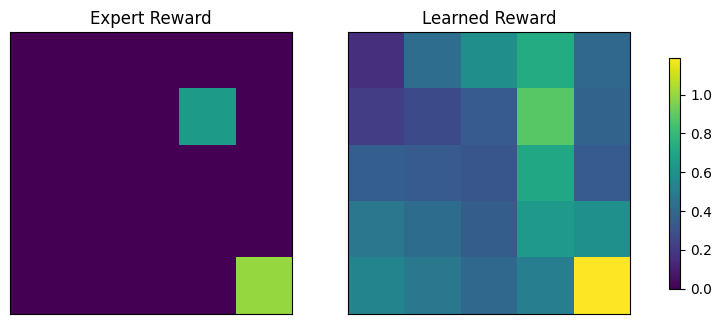

In [ ]:
# Visualization
import matplotlib.pyplot as plt

def plot_reward_comparison(world, expert_reward, learned_reward):
    side = world.size
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    vmin = min(expert_reward.min(), learned_reward.min())
    vmax = max(expert_reward.max(), learned_reward.max())
    im0 = axes[0].imshow(expert_reward.reshape(side, side), cmap="viridis", vmin=vmin, vmax=vmax)
    axes[0].set_title("Expert Reward")
    axes[1].imshow(learned_reward.reshape(side, side), cmap="viridis", vmin=vmin, vmax=vmax)
    axes[1].set_title("Learned Reward")
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(im0, ax=axes.ravel().tolist(), shrink=0.75)
    plt.show()

plot_reward_comparison(world, expert_reward, learned_reward)




## 2. GRPO Fine-Tuning from Scratch [40 pts]

1. Conceptual questions [10 pts]
2. GRPO implementation [30 pts]

Group Relative Policy Optimization (GRPO) extends PPO for RLHF by sampling multiple responses per prompt and using their mean reward as a control variate. This stabilizes policy updates when rewards come from evaluators or heuristics--exactly the setting for aligning language and multimodal models.

**Suggested resources.**
- Zhihong Shao et al., *DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models*, 2024 (introduces GRPO)
- Hugging Face TRL blog, *GRPO: Group Relative Policy Optimization*
- lsdefine/simple_GRPO GitHub repository (minimal open-source implementation)

The remaining cells guide you through implementing the reward, advantage, and loss components so the GRPO training loop actually runs end-to-end.

**GRPO recap (Shao et al., 2024).** For each prompt $i$ we draw a group of $m$ completions $\{y_{i,j}\}_{j=1}^m$ from the policy. Rewards $r_{i,j}$ are centered with the group mean $\bar r_i = \tfrac{1}{m}\sum_j r_{i,j}$ to form advantages $A_{i,j} = r_{i,j} - \bar r_i$. The policy update maximizes the PPO-style surrogate $\min\big(r_{i,j}A_{i,j}, \operatorname{clip}(r_{i,j}, 1 \pm \epsilon)A_{i,j}\big)$ while subtracting a KL penalty $\beta\,\mathrm{KL}(\pi_\theta \Vert \pi_{\text{ref}})$ to keep the fine-tuned model close to the frozen reference. This notebook isolates each mathematical piece so you can test it in isolation before chaining them together.

**What you are implementing.** You will (a) code the structural reward checker, (b) normalize group advantages, (c) derive the GRPO loss from the log-prob ratios, and (d) plug everything into a gradient-accumulated training loop that mirrors Algorithm 1 in the paper. The surrounding evaluation cells verify that format adherence improves after RL fine-tuning.


### 2.a Conceptual Questions [10 pts total; 2 pts each]

1. Why does GRPO draw $G>1$ completions per prompt, and what is the prompt-level control variate used to center rewards?
<font color="blue">GRPO draws $G>1$ completions per prompt to obtain multiple samples from the same input, which enables variance reduction through the control variate. The prompt-level control variate is the group mean reward: $\bar{r}_i = \frac{1}{G}\sum_{j=1}^G r_{i,j}$, which is subtracted from each individual reward to center the advantages within each group.</font>

2. A prompt yields rewards $(2, 1, -1)$ with group size $G=3$. Compute the centered advantages for each completion.
<font color="blue">Mean: $\bar{r} = (2 + 1 + (-1))/3 = 2/3$
Standard deviation: $\sigma = \sqrt{\frac{1}{3}[(2-2/3)^2 + (1-2/3)^2 + (-1-2/3)^2]} = \sqrt{\frac{1}{3}[\frac{16}{9} + \frac{1}{9} + \frac{25}{9}]} = \sqrt{\frac{14}{9}} = \frac{\sqrt{14}}{3}$
Normalized advantages: $A = \frac{r - \bar{r}}{\sigma}$
- $A_1 = \frac{2 - 2/3}{\sqrt{14}/3} = \frac{4/3}{\sqrt{14}/3} = \frac{4}{\sqrt{14}} \approx 1.069$
- $A_2 = \frac{1 - 2/3}{\sqrt{14}/3} = \frac{1/3}{\sqrt{14}/3} = \frac{1}{\sqrt{14}} \approx 0.267$
- $A_3 = \frac{-1 - 2/3}{\sqrt{14}/3} = \frac{-5/3}{\sqrt{14}/3} = \frac{-5}{\sqrt{14}} \approx -1.336$</font>

3. Midway through training you double $\beta$ in the GRPO loss. Describe the effect this has on the update dynamics.
<font color="blue">Doubling $\beta$ increases the weight of the KL penalty term $\beta \, \mathrm{KL}(\pi_\theta \| \pi_{\text{ref}})$, which makes the policy updates more conservative. The model will stay closer to the reference policy, taking smaller steps in parameter space. This reduces the risk of catastrophic forgetting and mode collapse but may slow down learning from the reward signal.</font>

4. Starting from $r_t = \exp(\log p_\theta - \log p_{\text{ref}})$, write the clipped surrogate used by GRPO and explain how the clipping interacts with the sign of the advantage.
<font color="blue">The clipped surrogate is:
$$L_{\text{clip}} = \min(r_t A_t, \, \text{clip}(r_t, 1-\epsilon, 1+\epsilon) A_t)$$
When $A_t > 0$ (good action), we want to increase its probability, but clipping $r_t$ at $1+\epsilon$ prevents excessively large updates even if $r_t$ is very large.
When $A_t < 0$ (bad action), we want to decrease its probability, but clipping $r_t$ at $1-\epsilon$ prevents excessively large decreases even if $r_t$ is very small.
The min operation selects the more conservative of the two terms, ensuring stable updates.</font>

5. Format rewards are dense but answer-correctness rewards are sparse. Propose a shaping scheme that keeps correctness learning signal meaningful and justify it.
<font color="blue">Use a two-stage weighted scheme: $r_{\text{total}} = r_{\text{format}} + \lambda \cdot r_{\text{format}} \cdot r_{\text{correctness}}$, where $\lambda > 1$ is a scaling factor (e.g., 5-10). This gives a base reward for correct formatting, but multiplies the correctness reward by the format reward, so correctness only contributes when the format is correct. This encourages the model to first learn the format (dense signal) while preserving the learning signal for correctness (sparse but amplified). The multiplicative structure ensures correctness doesn't reinforce incorrect formats.</font>

### 2.b GRPO Implementation [30 pts]

Complete the reward shaping helpers, grouped-advantage computation, GRPO loss, and the short training/eval loop. Tests in Section 2 cover each of these components.


### Section 2 implementation guide

We now pivot to GRPO fine-tuning. The next block of cells loads libraries, defines the system & user prompts, constructs the reward function, and wires together helper utilities (log-prob extraction, grouped advantages, optimizer setup). Treat those as scaffolding so you can focus on the GRPO-specific TODOs and diagnostics. In particular, the device/import setup, dataset builder, model + LoRA configuration, and format/decoding helper cells are boilerplate—you do not need to edit them.

Expect to run the provided GRPO loop on GPU; with the given reward shaping it can drive format adherence close to 100% after enough steps. Format adherence thresholds are tiered: 50% post-RL earns 2 pts, 70% earns 4 pts, and 90% earns the full 6 pts, so feel free to keep training until you hit the ceiling.


In [ ]:
import math
import random
from collections import deque
from dataclasses import dataclass
from typing import List

import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model


torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
SYSTEM_PROMPT = (
    "You are a helpful assistant. First reason internally, then provide the user answer. "
    "Respond using the template:\n"
    "<think>\n"
    "...\n"
    "</think>\n"
    "<answer>\n"
    "...\n"
    "</answer>"
)

@dataclass
class QAExample:
    question: str
    answer: str


def build_dataset(num_examples: int = 64) -> Dataset:
    records = []
    for _ in range(num_examples):
        a = random.randint(10, 99)
        b = random.randint(1, 9)
        question = f"If you add {a} and {b}, what is the result?"
        answer = str(a + b)
        records.append({"question": question, "answer": answer})
    return Dataset.from_list(records)

train_ds = build_dataset()
train_ds[:3]


{'question': ['If you add 91 and 2, what is the result?',
  'If you add 13 and 5, what is the result?',
  'If you add 41 and 4, what is the result?'],
 'answer': ['93', '18', '45']}

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side="left")
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(base_model, lora_config)
model = model.to(device)
model.print_trainable_parameters()


trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


In [ ]:
import re

FORMAT_PATTERN = re.compile(r"^<think>\n[\s\S]*\n</think>\n<answer>\n[\s\S]*\n</answer>$", re.MULTILINE)

def format_reward(responses: List[str]) -> torch.Tensor:
    scores = [1.0 if FORMAT_PATTERN.match(resp.strip()) else 0.0 for resp in responses]
    return torch.tensor(scores, dtype=torch.float32, device=device)


In [ ]:
# Sanity checks for format_reward
valid_resp = "<think>\nreasoning goes here\n</think>\n<answer>\nthe meaning of life is\n</answer>"
invalid_resp = "<think>missing closing tags"
scores = format_reward([valid_resp, invalid_resp])
print('format_reward scores:', scores.cpu().tolist())
assert scores[0].item() == 1.0
assert scores[1].item() == 0.0


format_reward scores: [1.0, 0.0]


In [ ]:
def build_prompt(question: str) -> str:
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

prompts = [build_prompt(rec["question"]) for rec in train_ds]
prompts[0]


'<|im_start|>system\nYou are a helpful assistant. First reason internally, then provide the user answer. Respond using the template:\n<think>\n...\n</think>\n<answer>\n...\n</answer><|im_end|>\n<|im_start|>user\nIf you add 91 and 2, what is the result?<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
def completion_log_probs(model, sequences: torch.Tensor, prompt_lengths: torch.Tensor) -> torch.Tensor:
    attention_mask = (sequences != tokenizer.pad_token_id).long()
    outputs = model(input_ids=sequences, attention_mask=attention_mask)
    logits = outputs.logits[:, :-1, :]
    target_ids = sequences[:, 1:]
    log_probs = torch.log_softmax(logits, dim=-1)
    token_logps = torch.gather(log_probs, dim=-1, index=target_ids.unsqueeze(-1)).squeeze(-1)
    cont_logps = []
    for i in range(sequences.size(0)):
        prompt_len = prompt_lengths[i].item()
        total_len = attention_mask[i].sum().item()
        start = max(prompt_len - 1, 0)
        end = max(total_len - 1, start)
        cont_logps.append(token_logps[i, start:end].sum())
    return torch.stack(cont_logps)


@torch.no_grad()
def sample_group(
    model,
    prompts: List[str],
    num_generations: int = 2,
    max_new_tokens: int = 128,
    do_sample: bool = True,
    temperature: float = 0.9,
):
    encoded = tokenizer(prompts, return_tensors="pt", padding=True, add_special_tokens=False)
    prompt_lengths = encoded["attention_mask"].sum(dim=1)
    encoded = {k: v.to(device) for k, v in encoded.items()}

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "num_return_sequences": num_generations,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
    }
    if do_sample:
        gen_kwargs["temperature"] = temperature

    outputs = model.generate(**encoded, **gen_kwargs)

    batch_size = len(prompts)
    sequences = outputs.view(batch_size, num_generations, -1)
    seq_list = []
    prompt_len_list = []
    texts = []
    for i in range(batch_size):
        prompt_len = prompt_lengths[i].item()
        for g in range(num_generations):
            ids = sequences[i, g]
            mask = (ids != tokenizer.pad_token_id).long()
            seq_len = mask.sum().item()
            seq_list.append(ids)
            prompt_len_list.append(prompt_len)
            text_tokens = ids[prompt_len:seq_len]
            texts.append(tokenizer.decode(text_tokens, skip_special_tokens=True))
    stacked = torch.stack(seq_list).to(device)
    prompt_len_tensor = torch.tensor(prompt_len_list, device=device)
    rewards = format_reward(texts)
    return stacked, prompt_len_tensor, rewards, texts


In [ ]:
def compute_group_advantages(rewards: torch.Tensor, group_size: int) -> torch.Tensor:
    if group_size <= 0:
        raise ValueError(f"group_size must be positive; got {group_size}")
    num_rewards = rewards.numel()
    if num_rewards % group_size != 0:
        raise ValueError(
            f"Reward tensor of length {num_rewards} is not divisible by group_size={group_size}"
        )
    reshaped = rewards.view(-1, group_size)
    mean = reshaped.mean(dim=1, keepdim=True)
    std = reshaped.std(dim=1, keepdim=True, unbiased=False).clamp_min(1e-6)
    normalized = (reshaped - mean) / std
    return normalized.view(-1)


#### GRPO clipped surrogate with KL anchor

For each sampled sequence we form
$$r_t = \exp(\log p_\theta - \log p_{\text{ref}}), \qquad L_{\text{clip}} = \min(r_t A_t, \mathrm{clip}(r_t, 1\pm\epsilon) A_t).$$
The full loss subtracts a KL penalty against the frozen reference policy:
$$\mathcal{L}_{\text{GRPO}} = L_{\text{clip}} - \beta\,\mathrm{KL}(\pi_\theta\,\|\,\pi_{\text{ref}}).$$


In [ ]:
def grpo_sequence_loss(logp_new: torch.Tensor, logp_ref: torch.Tensor, advantages: torch.Tensor, beta: float, epsilon: float) -> torch.Tensor:
    # student code here
    # TODO: compute the clipped PPO-style surrogate and subtract the GRPO KL penalty term
    ratio = torch.exp(logp_new - logp_ref)
    clip_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    surr1 = ratio * advantages
    surr2 = clip_ratio * advantages
    clip_obj = torch.min(surr1, surr2)

    # KL divergence using Schulman (2020) estimator: r - log(r) - 1
    # where r = π_ref / π_θ
    kl_ratio = torch.exp(logp_ref - logp_new)
    kl = kl_ratio - torch.log(kl_ratio) - 1

    loss = -(clip_obj - beta * kl).mean()
    # end student code
    return loss


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
beta = 0.05
epsilon = 0.2
group_size = 2


def grpo_update(batch_prompts: List[str], grad_accum: int | None = None):
    accum_steps = grad_accum if grad_accum is not None else 1
    if accum_steps < 1:
        raise ValueError("grad_accum must be >= 1")

    optimizer.zero_grad()
    all_rewards: list[torch.Tensor] = []
    all_losses: list[torch.Tensor] = []
    collected_texts: list[str] = []

    for _ in range(accum_steps):
        sequences, prompt_lens, rewards, texts = sample_group(
            model,
            batch_prompts,
            num_generations=group_size,
        )

        logp_new = completion_log_probs(model, sequences, prompt_lens)

        adapters_supported = hasattr(model, "disable_adapter") and hasattr(model, "enable_adapter")
        if adapters_supported:
            model.disable_adapter()
        with torch.no_grad():
            logp_ref = completion_log_probs(model, sequences, prompt_lens)
        if adapters_supported:
            model.enable_adapter()

        advantages = compute_group_advantages(rewards, group_size)
        base_loss = grpo_sequence_loss(logp_new, logp_ref, advantages, beta=beta, epsilon=epsilon)
        (base_loss / accum_steps).backward()

        all_losses.append(base_loss.detach())
        all_rewards.append(rewards.detach())
        collected_texts.extend(texts)

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    reward_tensor = torch.cat(all_rewards)
    reward_mean = reward_tensor.mean().item()
    reward_std = reward_tensor.std().item() if reward_tensor.numel() > 1 else 0.0
    loss_value = torch.stack(all_losses).mean().item()

    return {
        "loss": loss_value,
        "reward_mean": reward_mean,
        "reward_std": reward_std,
        "format_match_pct": reward_mean * 100.0,
        "texts": collected_texts,
        "optimizer_step": True,
        "accumulated_microbatches": accum_steps,
        "grad_accum_steps": accum_steps,
    }


In [ ]:
# Unit tests for helpers

def check_tensor_close(name: str, actual: torch.Tensor, expected: torch.Tensor, atol: float = 1e-6):
    diff = torch.max(torch.abs(actual - expected)).item()
    if diff > atol:
        raise AssertionError(f"{name} mismatch (max |Δ|={diff:.3e}). Expected {expected}, got {actual}")
    print(f"[OK] {name}: max diff={diff:.2e}")

raw_rewards = torch.tensor([1.0, 0.0, 2.0, 4.0], device=device)
adv = compute_group_advantages(raw_rewards, group_size=2)
reshaped_adv = adv.view(2, 2)
check_tensor_close("Group advantage mean", reshaped_adv.mean(dim=1), torch.zeros(2, device=device))
check_tensor_close("Group advantage std", reshaped_adv.std(dim=1, unbiased=False), torch.ones(2, device=device))

logp_new = torch.log(torch.tensor([0.6, 0.4, 0.7, 0.3], device=device))
logp_ref = torch.log(torch.tensor([0.5, 0.5, 0.6, 0.4], device=device))
manual_adv = torch.tensor([1.2, -0.4, 0.5, -1.0], device=device)
loss = grpo_sequence_loss(logp_new, logp_ref, manual_adv, beta=0.1, epsilon=0.2)
check_tensor_close("GRPO loss test", loss, -0.2233469)

logp_new_grad = torch.log(torch.tensor([0.55, 0.45, 0.65, 0.35], device=device))
logp_new_grad.requires_grad_(True)
loss_grad = grpo_sequence_loss(logp_new_grad, logp_ref, manual_adv, beta=0.05, epsilon=0.2)
loss_grad.backward()
if not torch.all(torch.isfinite(logp_new_grad.grad)):
    raise AssertionError("Non-finite gradients detected in GRPO loss")
print(f"[OK] GRPO loss backward pass: grad norm={logp_new_grad.grad.norm().item():.4f}")

print("Section 2 helper tests passed.")



[OK] Group advantage mean: max diff=0.00e+00
[OK] Group advantage std: max diff=0.00e+00
[OK] GRPO loss test: max diff=1.49e-08
[OK] GRPO loss backward pass: grad norm=0.4256
Section 2 helper tests passed.


In [ ]:
def evaluate_format_rate(
    model,
    dataset,
    num_examples: int | None = 32,
    num_generations: int = 1,
    max_new_tokens: int = 128,
    do_sample: bool = False,
):
    if num_examples is None:
        subset = dataset
    else:
        size = min(num_examples, len(dataset))
        subset = dataset.select(range(size))
    effective_generations = num_generations
    if not do_sample and num_generations != 1:
        effective_generations = 1
    prompts = [build_prompt(ex["question"]) for ex in subset]
    _, _, rewards, texts = sample_group(
        model,
        prompts,
        num_generations=effective_generations,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
    )
    total = rewards.numel()
    matches = rewards.sum().item()
    rate = (matches / total) * 100 if total else 0.0
    print(f"Format adherence: {rate:.1f}%")
    return rate, texts


### Format evaluation and demo training loop

---



After defining the helpers, we first measure baseline format adherence, then run a short GRPO training loop. Aim for at least 90% post-training adherence to receive full credit (the performance can climb near 100% after 25 steps if done correctly). Training should take approximately 30 minutes in Colab with a T4 GPU.

Again, 50% post-RL earns 2 pts, 70% earns 4 pts, and 90% earns the full 6 pts.


In [ ]:
history = deque(maxlen=10)
eval_subset = train_ds.select(range(min(32, len(train_ds))))
print("Baseline format adherence (pre-RL):")
baseline_rate, _ = evaluate_format_rate(
    model,
    eval_subset,
    num_examples=None,
    num_generations=group_size,
    do_sample=False,
)

Baseline format adherence (pre-RL):
Format adherence: 0.0%


In [ ]:
import time
start_time = time.time()
for step in range(25):
    batch = train_ds.shuffle(seed=step).select(range(4))  # batch size 4
    prompts_batch = [build_prompt(ex["question"]) for ex in batch]
    stats = grpo_update(prompts_batch, grad_accum=8)  # simulate batch size 4x8=32
    history.append(stats["reward_mean"])
    print(
        f"Step {step + 1:02d} | reward_mean={stats['reward_mean']:.3f} | format adherence={stats['format_match_pct']:.1f}% | time={(time.time() - start_time):.1f}s"
    )


Step 01 | reward_mean=0.000 | format adherence=0.0% | time=47.3s
Step 02 | reward_mean=0.000 | format adherence=0.0% | time=107.7s
Step 03 | reward_mean=0.047 | format adherence=4.7% | time=158.3s
Step 04 | reward_mean=0.000 | format adherence=0.0% | time=219.2s
Step 05 | reward_mean=0.062 | format adherence=6.2% | time=270.4s
Step 06 | reward_mean=0.047 | format adherence=4.7% | time=322.7s
Step 07 | reward_mean=0.141 | format adherence=14.1% | time=370.7s
Step 08 | reward_mean=0.172 | format adherence=17.2% | time=417.1s
Step 09 | reward_mean=0.219 | format adherence=21.9% | time=462.2s
Step 10 | reward_mean=0.266 | format adherence=26.6% | time=505.4s
Step 11 | reward_mean=0.328 | format adherence=32.8% | time=545.3s
Step 12 | reward_mean=0.375 | format adherence=37.5% | time=590.2s
Step 13 | reward_mean=0.297 | format adherence=29.7% | time=639.7s
Step 14 | reward_mean=0.422 | format adherence=42.2% | time=687.8s
Step 15 | reward_mean=0.500 | format adherence=50.0% | time=721.5s
St

In [ ]:
print("Format adherence after RL:")
post_rate, _ = evaluate_format_rate(
    model,
    eval_subset,
    num_examples=None,
    num_generations=group_size,
    do_sample=False,
)
print(f"Baseline: {baseline_rate:.1f}% | Post-RL: {post_rate:.1f}%")

Format adherence after RL:
Format adherence: 100.0%
Baseline: 0.0% | Post-RL: 100.0%


## Submission Checklist

- All answers filled.
- Section 1 tests succeed; visualization optional.
- Section 2 helper tests succeed; optional demo loop left commented.


### Chain-of-Thought Playground Example

Use this cell to poke the fine-tuned model with your own prompts. We start with a simple 4-digit addition problem so you can see the expected <think>/<answer> chain of thought. Edit `example_question` and re-run as you like.


In [ ]:
example_question = "What's 4821+11?"
example_prompt = build_prompt(example_question)
print("Prompt:", example_question)

inputs = tokenizer(example_prompt, return_tensors="pt", padding=True, add_special_tokens=False).to(device)
input_len = inputs["input_ids"].shape[1]
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
new_tokens = output_ids[0, input_len:]
completion = tokenizer.decode(new_tokens, skip_special_tokens=True)
print("Model completion:")
print(completion.strip())

Prompt: What's 4821+11?
Model completion:
<think>
To solve 4821 + 11, you simply add them together.
</think>
<answer>
4932
</answer>
